In [ ]:
import matplotlib.pyplot as plt
import torch, gym, numpy as np
from data_processing.neural_networks.DEEP_RL_Deep_Reinfocement_Learning.DEEP_RL_funcs import env_info, policy, value

(observed episode) trajectory of states and actions (time = T is terminal):
$$\tau = \{s_0, a_0, s_1,\dots\,s_{T-1}, a_{T-1}, s_T\}$$
_notice there is no action $a_T$ from terminal state $s_T$._

(observed episode) rewards from trajectory"
$$ r_\tau =  \{r_0, r_1,\dots,r_T\}$$
finite-horizon undiscounted return:
$$ R(\tau) = \sum_{t = 0}^T r_t$$
finite-horizon discounted return:
$$ R(\tau) = \sum_{t = 0}^T \gamma^t r_t$$
Policy $\pi$ decides which actions to take from state $s$:
$$\pi = \pi(a_t|s_t) \ (\forall t \in [0,1,\dots, T - 1])$$
Stochasticity of environment shows itself in probabilistic response to actions:
$$P(s_{t+1}|s_t,a_t)$$
Probability of a trajectory under policy $\pi$:
$$P(\tau|\pi) = \rho_0(s_0) \cdot \pi(a_0|s_0) \cdot P(s_1|s_0,a_0)\cdot\pi(a_1|s_1)\cdot P(s_2|s_1,a_1)\cdot \dots$$
$$ = \rho_0(s_0)\cdot \prod_{t=0}^{T-1} \pi(a_t|s_t) \cdot P(s_{t+1}|s_t,a_t)$$
_where $\rho_0(s_0)$ is a probability of starting in state $s_0$. Its controlled by environment._

_we employ Markov property here to get rid of the history:_
$$P(s_{t+2}|s_t,s_{t+1},a_t,a_{t+1}) = P(s_{t+2}|s_{t+1}, a_{t+1})$$

We can measure performance $J(\pi)$ of a given policy $\pi$ by examining many trajectories $\tau \in D$, their cumulative rewards $R(\tau)$. This can be done by computing expected rewards:
$$\boxed{J(\pi) = \sum_{\tau \in D} P(\tau|\pi) \cdot R(\tau) = \underset{\tau \sim \pi}{\mathbb{E}}[R(\tau)]}$$

In most cases policy should be approximated by parametric representation 
$$\pi_{\vec{\theta}}=\pi(a|s,\vec{\theta})$$
, where $\vec{\theta}$ is a vector of parameters. _I will omit vector sign in the future._

Approximation can be learned by performing gradient de-/ascent:
$$\theta_{t+1} = \theta_t + \alpha \nabla_{\theta} J(\pi_{\theta_t})$$
where $t$ are 'time steps' at which wight update is conducted.

in order to determine 
$$\nabla_{\theta} J(\pi_{\theta}) =  \sum_{\tau \in D} \nabla_{\theta} \bigg[P(\tau|\pi_{\theta}) \cdot R(\tau) \bigg]$$ 
we can leverage this identity:
$$\nabla_{\theta}P(\tau|\theta) = P(\tau|\theta)\cdot\nabla_{\theta} \ log P(\tau|\theta)$$
and calculate part of right term (_products turn to sums under $log()$ and most stuff cancels_):
$$\nabla_{\theta} \ log \ P(\tau|\theta) = 
\nabla_{\theta} \log \ \bigg[\rho_0(s_0)\cdot \prod_{t=0}^{T} \pi_\theta(a_t|s_t) \cdot P(s_{t+1}|s_t,a_t) \bigg] = 
\sum_{t=0}^{T} \nabla_{\theta} \ log \ \pi_\theta(a_t|s_t)$$
After few mathematical manipulations:
$$\boxed{\nabla_{\theta} J(\pi_{\theta}) =  \sum_{\tau \in D}  P(\tau|\theta) \cdot \bigg[ \sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) \cdot R(\tau)\bigg] = \underset{\tau \sim \pi}{\mathbb{E}}\bigg[ \sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) \cdot R(\tau) \bigg]}$$
where expectation is taken over probability of a trajectory, _but given many sample episodes it can be estimated by a mean_:
$$\underset{\tau \sim \pi}{\mathbb{E}}[\ \cdot \ ] \longrightarrow \frac{1}{|D|} \sum_{\tau \in D}[\ \cdot \ ]$$

$$\boxed{\nabla_{\theta} J(\pi_{\theta}) =  \frac{1}{|D|} \sum_{\tau \in D}R(\tau)\cdot\sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) }$$

As i understand it, policy can converge under stochastic gradient descent, with $\frac{1}{|D|}$ being absorbed into step size.

So objective function can be optimized into direction of:
$$\nabla_{\theta} J^\prime(\pi_{\theta}) = R(\tau)\cdot\sum_{t=0}^{T} \nabla_{\theta} \ log  \ \pi_\theta(a_t|s_t) =\nabla_{\theta} \bigg[ R(\tau)\cdot\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \bigg]$$
at the end of each episode.

Thus objective function can be defined as
$$L(\tau) =  R(\tau)\cdot\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) $$ 
which can be maximized using other variation of gradient as-/descent.

Maybe initial episodes are too short so OpenAi's 'spinningup' offers to __batch many episodes start-to-back__ before doing grad update

In [2]:
env_CP      = env_info('CartPole-v1')
num_obs     = env_CP.env.observation_space.shape[0]
num_acts    = env_CP.env.action_space.n
env_CP_policy   = policy(   num_obs, num_acts   , [32])
progress        = []

In [3]:
from tqdm import tqdm
batch_size = 5000
tq_iter = tqdm(range(50))
for _ in tq_iter:
    env_CP.clear_batches()
    obs                  = env_CP.reset()
    t                    = 0
    batch_times          = []

    while True:
        action = env_CP_policy.get_action(obs)
        obs, rew, episode_finished = env_CP.step(action)
        t += 1
        if episode_finished or t >= 300:
            env_CP.env_iters += 1
            batch_times.append(t)

            env_CP.add_ep_rewards_cum()
            t = 0
            if len(env_CP.batch_states) >= batch_size: 
                break               # end of batch. dont add terminal obs to batch_state
            obs = env_CP.reset()    # start new episode. adds obs to batch_state
        else:
            env_CP.batch_states.append(obs)

    env_CP_policy.optimizer.zero_grad()

    log_probs = env_CP_policy.log_prob(env_CP.batch_states,env_CP.batch_actions)

    output = -log_probs*(torch.as_tensor(env_CP.batch_rewards))
    output = output.mean()
    output.backward()
    env_CP_policy.optimizer.step()
    std_steps, avg_steps = torch.std_mean(torch.as_tensor(batch_times).to(float))
    tq_iter.set_postfix(std_steps = std_steps.item(), avg_steps = avg_steps.item(), env_iters = env_CP.env_iters)
    #print(f'{avg_steps = :0.2f}, {std_steps = :0.2f}')
    progress.append(avg_steps)

100%|██████████| 50/50 [01:47<00:00,  2.16s/it, avg_steps=279, env_iters=2873, std_steps=53.4] 


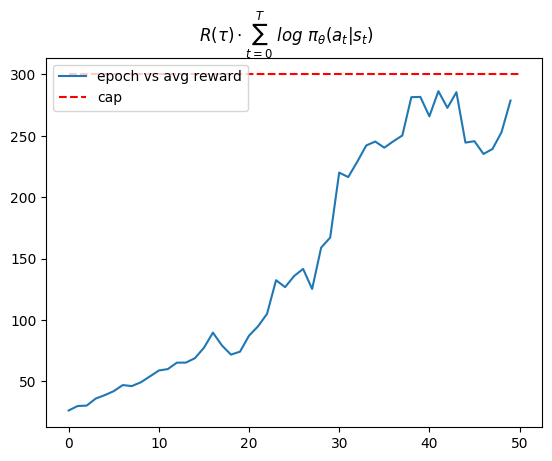

In [4]:
plt.plot(progress, label='epoch vs avg reward')    ;
plt.hlines(300, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()
plt.suptitle(r'$R(\tau)\cdot\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t)$');

## Watch agent play an episode

In [5]:
n=1000

env = gym.make("CartPole-v1", render_mode="human")

observation, info = env.reset(seed=82)

for _ in tqdm(range(n)):
    action = env_CP_policy.get_action(obs)
    observation,reward, terminated, truncated, info = env.step(action)
    #print("info : ",info);
    
    if terminated or truncated:
        observation, info = env.reset()
        break
        
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
  1%|          | 8/1000 [00:00<00:25, 39.63it/s]


## Replace cumulative reward for eachs tep with 'rewards 2 go'

One can change weighting of log-probabilities $\pi_\theta(a_t|s_t)$ to take account only future reward from time $t$:
$$L(\tau) = \sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot \sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1})$$
Sutton and Bartol would write these rewards as $G_{t^\prime:T}$

Of course it can be done only in the end of episode (via reversed cum-sum).

In [6]:
env_CP_policy   = policy(   num_obs, num_acts   , [32])
progress        = []

In [7]:
from tqdm import tqdm
batch_size = 5000
tq_iter = tqdm(range(50))
for _ in tq_iter:
    env_CP.clear_batches()
    obs                  = env_CP.reset()
    t                    = 0
    batch_times          = []

    while True:
        action = env_CP_policy.get_action(obs)
        obs, rew, episode_finished = env_CP.step(action)
        t += 1
        if episode_finished or t >= 300:
            env_CP.env_iters += 1
            batch_times.append(t)

            env_CP.add_ep_rewards_2_go()
            t = 0
            if len(env_CP.batch_states) >= batch_size: 
                break               # end of batch. dont add terminal obs to batch_state
            obs = env_CP.reset()    # start new episode. adds obs to batch_state
        else:
            env_CP.batch_states.append(obs)

    env_CP_policy.optimizer.zero_grad()

    log_probs = env_CP_policy.log_prob(env_CP.batch_states,env_CP.batch_actions)

    output = -log_probs*(torch.as_tensor(env_CP.batch_rewards))
    output = output.mean()
    output.backward()
    env_CP_policy.optimizer.step()
    std_steps, avg_steps = torch.std_mean(torch.as_tensor(batch_times).to(float))
    tq_iter.set_postfix(std_steps = std_steps.item(), avg_steps = avg_steps.item(), env_iters = env_CP.env_iters)
    progress.append(avg_steps)

100%|██████████| 50/50 [01:44<00:00,  2.09s/it, avg_steps=278, env_iters=4146, std_steps=45.1] 


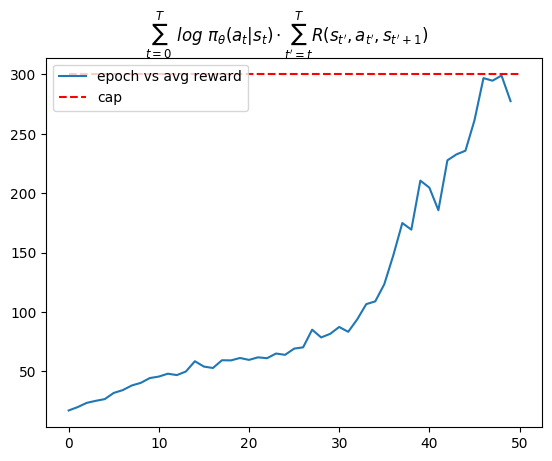

In [8]:
plt.plot(progress, label='epoch vs avg reward')    ;
plt.hlines(300, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()
plt.suptitle(r'$\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot \sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1})$');

# Inclusion of baseline
Additional modification is to include a _baseline function_ $b(s_t)$, so:
$$L(\tau) = \sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot \bigg(\sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)\bigg)$$
This can be a __state value function__, which should __learned__ parallel to policy.

## Test value function fit
we have to approximate value function. Test approximation via NN beforehand.

c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


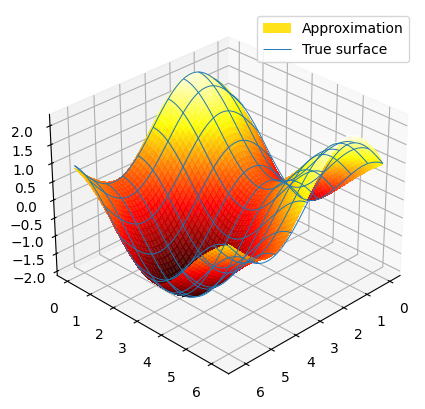

In [50]:
def target_fn(x,y):
  return (torch.sin(x) + torch.cos(y))

def target_fn_noisy(x,yy):
  r = target_fn(x,yy)
  return r + 0.05 * torch.randn(size=r.shape)

val_fn = value(2,1,[32])
x,y = xyT = 2.0 * torch.pi *  torch.rand(size = (200,2), dtype = float).T
target = target_fn_noisy(x,y)
#print(target.shape)
val_fn.train(xyT.T, target.reshape(-1,1),n_iters= 1000)
res = 100
x = torch.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
y = torch.arange(0.0, 2.0 * np.pi, 2.0 * np.pi / res)
z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    z[i,j] =  val_fn.get_value(torch.Tensor([x[i],y[j]]).to(float))[0].detach().item()
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d',computed_zorder=False)
X, Y = torch.meshgrid(x, y)
surf = ax.plot_surface(X.numpy(), Y.numpy(), z, cmap=plt.get_cmap('hot'), linewidth=1.5, antialiased=False, alpha = 0.9, label='Approximation')
Z = target_fn(X,Y).reshape(res,res)
ax.plot_wireframe(X.numpy(), Y.numpy(), Z.numpy(), rstride=10, cstride=10, linewidth = 0.7, label='True surface')#, zorder = 100)
ax.view_init(elev=30., azim=45)
plt.legend()
plt.show()

## Actual baseline implementation
if a batch consists of the following
$$\vec{S} = \{ \underbrace{s_0^1, s_1^1, \dots, s_{H_1 - 1}^1}_{\text{episode 1}}, \underbrace{s_0^2, s_1^2,\dots, s_{H_2 - 1}^2}_{\text{episode 2}},\dots \}$$
$$\vec{A} = \{ a_0^1, a_1^1, \dots, a_{H_1 - 1}^1, a_0^2, a_1^2,\dots \}$$
_where $H_i$ is a terminal time step for episode $i$,_ and instead of $R$
$$\vec{R} = \{ r_0^1, r_1^1, \dots, r_{H_1 - 1}^1, r_0^2, r_1^2,\dots \}$$
we calculate cumulative future rewards $G$
$$\vec{G} = \{ \underbrace{G_{0:H_1 - 1}^1, G_{1:H_1 - 1}^1, \dots, r_{H_1 - 1}}_{\text{episode 1}}, G_{0:H_2 - 1}^2, G_{1:H_2 - 1}^2, \dots   \}$$
where
$$G_{t:H - 1} = \sum_{t^\prime = t}^{H-1} R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1})$$
which we did in last case, then we can calculate loss $L(\phi)$ of $V_\phi(s_i)$ as
$$L(\phi) = \frac{1}{|\vec{S}|}\sum \{\vec{V}_\phi(\vec{S}) - \vec{G}\}^2$$
where 
$$\vec{V}_\phi(\vec{S}) = \{V_\phi(s_0^1),V_\phi(s_1^1),\dots \}$$
_probly normalization is not very correct_

Source from https://spinningup.openai.com/en/latest/algorithms/vpg.html

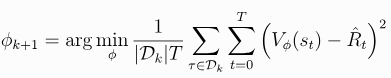

In [15]:
env_CP_policy   = policy(   num_obs, num_acts   , [32])
env_CP_value    = value(    num_obs, 1          , [32], lr = 0.1)
progress        = []


$$L(\tau) = \sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot \bigg(\sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)\bigg)$$


In [16]:
from tqdm import tqdm
batch_size = 5000
tq_iter = tqdm(range(50))
for _ in tq_iter:
    env_CP.batch_states  = []
    env_CP.batch_actions = []
    env_CP.batch_rewards = []
    obs                  = env_CP.reset()
    t                    = 0
    batch_times          = []

    while True:
        action = env_CP_policy.get_action(obs)
        obs, rew, episode_finished = env_CP.step(action)
        t += 1
        if episode_finished or t >= 300:
            env_CP.env_iters += 1
            batch_times.append(t)

            env_CP.add_ep_rewards_2_go()
            t = 0
            if len(env_CP.batch_states) >= batch_size: 
                break               # end of batch. dont add terminal obs to batch_state
            obs = env_CP.reset()    # start new episode. adds obs to batch_state
        else:
            env_CP.batch_states.append(obs)

    env_CP_policy.optimizer.zero_grad()
    env_CP_value.train(env_CP.batch_states, env_CP.batch_rewards, n_iters=10)

    log_probs = env_CP_policy.log_prob(env_CP.batch_states,env_CP.batch_actions)
    b_s       = env_CP_value.get_value(env_CP.batch_states)

    output = -log_probs*(torch.as_tensor(env_CP.batch_rewards) - b_s.flatten())
    output = output.mean()
    output.backward()
    env_CP_policy.optimizer.step()
    std_steps, avg_steps = torch.std_mean(torch.as_tensor(batch_times).to(float))
    tq_iter.set_postfix(std_steps = std_steps.item(), avg_steps = avg_steps.item(), env_iters = env_CP.env_iters)
    #print(f'{avg_steps = :0.2f}, {std_steps = :0.2f}')
    progress.append(avg_steps)

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 50/50 [01:47<00:00,  2.16s/it, avg_steps=294, env_iters=2195, std_steps=25]   


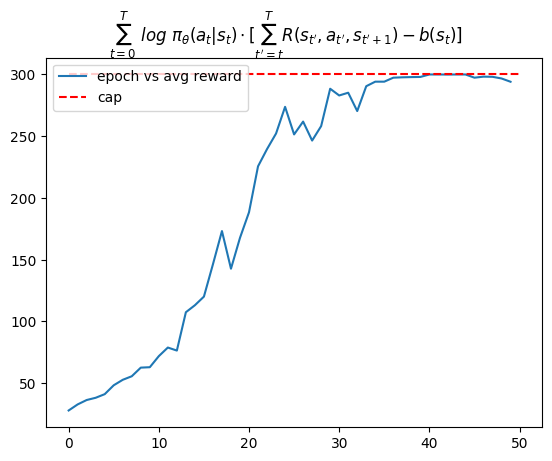

In [17]:
plt.plot(progress, label='epoch vs avg reward')    ;
plt.hlines(300, 0, len(progress), linestyles='--', label='cap', colors= 'r')
plt.legend()
plt.suptitle(r'$\sum_{t=0}^{T} \ log  \ \pi_\theta(a_t|s_t) \cdot [\sum_{t^\prime = t}^T R(s_{t^\prime}, a_{t^\prime}, s_{t^\prime +1}) -b(s_t)]$');

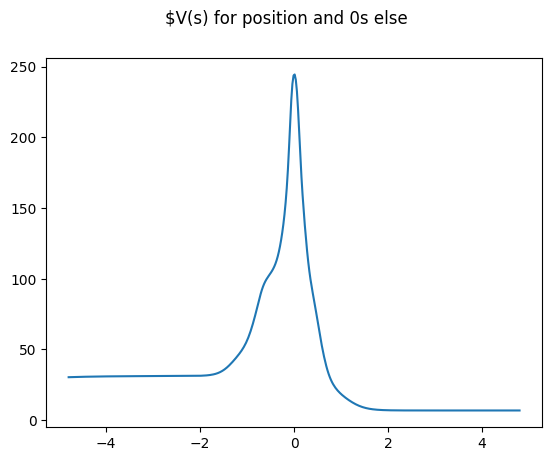

In [18]:
pos_min = env_CP.env.observation_space.low[0]
pos_max = env_CP.env.observation_space.high[0]
pos = torch.linspace(pos_min,pos_max, 400)
comb = torch.vstack((pos,torch.zeros_like(pos),torch.zeros_like(pos),torch.zeros_like(pos))).T
with torch.no_grad():
    y = env_CP_value.get_value(comb).detach().numpy()
    x = pos.numpy()
    plt.plot(x,y)
    plt.suptitle(r'$V(s) for position and 0s else')